# 02 - Image Classification Model Training 

Image classification model, using data generated from `01_generate_images.ipynb`


## Pre-requisites 

1. Setup Google Cloud project (See [README.md](README.md) for full details )
2. Create Vertex AI Workbench instance (See [README.md](README.md) for full details )
3. Run notebook [01_generate_images.ipynb](src/01_generate_images.ipynb)

## Install required packages

Run the cell below to check if required packages are installed.

If any are not, they will be installed and kernel will automatically restart and show a notificaiton.

If they are already installed, nothing will happen and proceed to the next step.

In [ ]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('PIL', 'Pillow'),
    ('tensorflow', 'tensorflow'),
    ('sklearn', 'scikit-learn'),
    ('gcsfs', 'gcsfs')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### Restart Kernel (If Installs Occured)
After a kernel restart the code submission can start with the next cell after this one.

In [ ]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Set Constants 

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'demos-vertex-ai'

In [3]:
## TODO - SET USER FLAG (either 'test' or 'prod') #############
user_flag = 'test'

# Basic input validation
if user_flag not in ['test', 'prod']:
    raise ValueError("Invalid input. Please enter either 'test' or 'prod'.")
    
print("=" * 80)
print(f"User flag set to: {user_flag}")
print("=" * 80)

User flag set to: test


In [4]:
LOCATION = "us-central1"  
REGION = 'us-central1' 

BUCKET_NAME = PROJECT_ID + "-" + "fruit-veg-image-classification"

DIR = 'data'
LOCAL_CSV_IMAGE_DATA_PATH = 'data/labels.csv'

DATASET_CSV = f"gs://{BUCKET_NAME}/labels.csv"
DATASET_VALIDATION_SPLIT = 0.2  # 20% for validation

# Choose values based on user flag #################
if user_flag == 'test':
    # REPLICA_COUNT = '4' # TODO - add to customJob config?
    MACHINE_TYPE = 'n1-standard-8'
elif user_flag == 'prod':
    ## prod
    # REPLICA_COUNT = '7' # TODO - add to customJob config?
    MACHINE_TYPE = 'c2-standard-60'

REPO_NAME = "fruit-veg-image-classification"
IMAGE_NAME = "tf_training"
IMAGE_TAG = "latest"
IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{REPO_NAME}/{IMAGE_NAME}:{IMAGE_TAG}"

MODEL_URI = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5" 
## TODO - try head-less since adding our own on top later 
# MODEL_URI = "https://tfhub.dev/google/imagenet/resnet_v2_50/vector/5" 
JOB_DISPLAY_NAME = 'fruit_veg_image_classification_training'

## Packages

In [5]:
import pandas as pd
from google.cloud import storage

import os
import json 
import tensorflow as tf
from google.cloud import aiplatform, storage
import pandas as pd
from sklearn.model_selection import train_test_split
import tempfile  # For creating temporary files
from concurrent.futures import ThreadPoolExecutor

import threading
import time

import random
from PIL import Image  # For image loading and preprocessing
import numpy as np

2024-09-10 15:47:31.471841: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 15:47:31.476578: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 15:47:31.490539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 15:47:31.513397: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 15:47:31.520160: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 15:47:31.536979: I tensorflow/core/platform/cpu_feature_gu

### Create a local directories for staging files 

* data files from creating labels.csv
* build files for creating custom container and running a custom job 
* model training output files and example input images for local inference

In [6]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

In [7]:
if not os.path.exists('build'):
    os.makedirs('build')

In [8]:
if not os.path.exists('output'):
    os.makedirs('output')

## Clients

In [9]:
storage_client = storage.Client(project=PROJECT_ID)
aiplatform.init(project=PROJECT_ID, location=REGION)

## Enable APIs

In [10]:
%%bash
# 1. Get the list of CURRENTLY ENABLED services
enabled_services=$(gcloud services list --enabled | awk '{print $1}')

# 2. Services we WANT to ensure are enabled
services_to_enable=("storage.googleapis.com" "artifactregistry.googleapis.com" "cloudbuild.googleapis.com")

# 3. Check each desired service against the enabled list
for service in "${services_to_enable[@]}"; do
    if ! echo "$enabled_services" | grep -q "$service"; then
        echo "Enabling $service..."
        gcloud services enable "$service"
    else
        echo "$service is already enabled."
    fi
done

storage.googleapis.com is already enabled.
artifactregistry.googleapis.com is already enabled.
cloudbuild.googleapis.com is already enabled.


## Create csv labels file and upload for use in model training

Create a csv file called `labels.csv` with the schema:  `gs://filename.jpg, label` 

This file should contain no headers and be located in GCS 

In [20]:
def get_file_list(bucket_name):
    # get list of all files from bucket
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs()
    file_list = ['gs://' + bucket_name + '/' + blob.name for blob in blobs]
    
    return file_list

In [21]:
file_list = get_file_list(BUCKET_NAME)
file_list[:10]

['gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cookie_sheet_10655_20240910153920.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cookie_sheet_45029_20240910154106.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cookie_sheet_53289_20240910154112.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cookie_sheet_59354_20240910153859.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cookie_sheet_70379_20240910153946.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cookie_sheet_80489_20240910154023.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cookie_sheet_92381_20240910153906.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cutting_board_49491_20240910153953.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification/apple_ripe_cutting_board_70368_20240910153940.jpg',
 'gs://demos-vertex-ai-fruit-veg-image-classification

In [24]:
def create_dataframe(file_list):
    # filter to include on filenames with jpeg filename
    jpeg_files = [file for file in file_list if file.endswith(('.jpg', '.jpeg'))]
    df = pd.DataFrame(jpeg_files, columns=['filename'])
    # Extract the label by first removing the GCS prefix, then splitting the blobname, and finally extracting the relevant part
    df['label'] = df['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[:2]))   
    
    return df

In [25]:
df_data = create_dataframe(file_list)
df_data.head()

,filename,label
0,gs://demos-vertex-ai-fruit-veg-image-classific...,apple_ripe
1,gs://demos-vertex-ai-fruit-veg-image-classific...,apple_ripe
2,gs://demos-vertex-ai-fruit-veg-image-classific...,apple_ripe
3,gs://demos-vertex-ai-fruit-veg-image-classific...,apple_ripe
4,gs://demos-vertex-ai-fruit-veg-image-classific...,apple_ripe


In [37]:
df_data.shape[0]

99

In [38]:
## optional - sanity check to ensure no non-image files exist the labels.csv 
# filtered_df = df_data[~df_data['filename'].str.contains('.csv')]
# if filtered_df.shape[0]:
#     print("Not good! Check your bucket, some potentially bad rows or files.")
# else:
#     print("No bad rows or files. All good!")

In [39]:
if user_flag == 'test':
    df_data.head(1000).to_csv(LOCAL_CSV_IMAGE_DATA_PATH, index=False, header=False)
elif user_flag == 'prod':
    df_data.to_csv(LOCAL_CSV_IMAGE_DATA_PATH, index=False, header=False)

In [40]:
bucket = storage_client.bucket(BUCKET_NAME)
blob = bucket.blob('labels.csv') 
blob.upload_from_filename(LOCAL_CSV_IMAGE_DATA_PATH)

## Model Training

### Data pre-processing

In [41]:
# --- Preprocessing ---
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_tfrecord_from_gcs(gcs_path, label, tfrecord_writer, storage_client, label_map):
    """Creates a TFRecord from an image in GCS and writes it to the writer."""
    try:
        bucket_name, blob_name = gcs_path[5:].split('/', 1)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        
        with tempfile.NamedTemporaryFile() as temp_file:
            blob.download_to_filename(temp_file.name)
            with open(temp_file.name, 'rb') as image_file:
                image_string = image_file.read()

        # Convert label to integer using the label map
        label_int = label_map[label]

        feature = {
            'image/encoded': _bytes_feature(image_string),
            'image/class/label': _int64_feature(label_int)
        }
        example = tf.train.Example(features=tf.train.Features(feature=feature))
        tfrecord_writer.write(example.SerializeToString())
    except Exception as e:
        print(f"Error processing {gcs_path}: {e}")


def create_and_upload_tfrecord(split_name, df, bucket, storage_client, label_map):
    """Creates a TFRecord file from the DataFrame and uploads it to GCS."""
    blob_name = f"{split_name}.tfrecord"
    blob = bucket.blob(blob_name)
    writer_lock = threading.Lock()
    error_occurred = False  # Flag to track errors

    with tempfile.NamedTemporaryFile() as temp_file:
        writer = tf.io.TFRecordWriter(temp_file.name)
        for row in df.itertuples():
            try:
                create_tfrecord_from_gcs(row.image_path, row.label, writer, storage_client, label_map)
            except Exception as e:
                print(f"Error processing {row.image_path}: {e}")
                error_occurred = True  # Set the flag if an error occurs

        writer.close()

        # Check if any errors occurred before uploading
        if not error_occurred:
            blob.upload_from_filename(temp_file.name, timeout=600) # to avoid any connection timeout issues
            print(f"Uploaded {blob_name} to GCS.")
        else:
            print(f"Not uploading {blob_name} due to errors during TFRecord creation.")

# --- Main Preprocessing Function ---
def preprocess_data():
    """Reads CSV, splits data, creates label map, and creates/uploads TFRecords."""
    df = pd.read_csv(DATASET_CSV, header=None, names=['image_path', 'label'])
    train_df, val_df = train_test_split(df, test_size=DATASET_VALIDATION_SPLIT, random_state=42)

    # Create a label map (dictionary mapping labels to integer IDs)
    unique_labels = df['label'].unique()
    label_map = {label: i for i, label in enumerate(unique_labels)}

    storage_client = storage.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(BUCKET_NAME)

    # save label map to GCS for use in prediction later 
    blob = bucket.blob("label_map.json")  # Specify GCS path for label_map.json here
    blob.upload_from_string(json.dumps(label_map), content_type='application/json')

    create_and_upload_tfrecord('train', train_df, bucket, storage_client, label_map)
    create_and_upload_tfrecord('val', val_df, bucket, storage_client, label_map)

### Execute pre-processing 

Create TFRecords files in GCS bucket

In [42]:
preprocess_data() 

Uploaded train.tfrecord to GCS.
Uploaded val.tfrecord to GCS.


## Create Training Script

In [43]:
%%writefile build/train.py
import os
import tensorflow as tf
import tensorflow_hub as hub

# Get Environment Variables
TFRECORD_PATH = os.environ['AIP_TFRECORD_PATH']
VALIDATION_PATH = os.environ['AIP_VALIDATION_PATH']
OUTPUT_PATH = os.environ['AIP_OUTPUT_PATH']
MODEL_URI = os.environ['MODEL_URI']

# sanity check TF version
print(f"TensorFlow version: {tf.__version__}")

# Load the TFRecords
def parse_tfrecord(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match model input
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    label = tf.cast(example['image/class/label'], tf.int32)
    return image, label


def get_dataset(filename):
    return tf.data.TFRecordDataset(filename).map(parse_tfrecord).shuffle(1000).batch(32).prefetch(1)

train_dataset = get_dataset(TFRECORD_PATH)
val_dataset = get_dataset(VALIDATION_PATH)

# Load the TensorFlow Hub model
model = hub.KerasLayer(MODEL_URI, trainable=False)

# Add your custom classification head
num_classes = 6  # CHECK - set this to the number of classes in your dataset ###########################
model = tf.keras.Sequential([
    model,
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

# Save the model
model.save(OUTPUT_PATH)

Overwriting build/train.py


### Create Dockerfile

Refs:

* https://cloud.google.com/vertex-ai/docs/training/pre-built-containers

In [44]:
%%writefile build/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-11:latest

# Set the working directory
WORKDIR /root

# Install dependencies
RUN pip install tensorflow-hub==0.12.0

# Copy the training script
COPY train.py /root/train.py

# Define the entry point
ENTRYPOINT ["python", "train.py"]

Overwriting build/Dockerfile


## Build Container Image

### Create docker repository


In [45]:
!gcloud artifacts repositories create {REPO_NAME} --repository-format=docker --location={REGION} --description="Docker repository"

ERROR: (gcloud.artifacts.repositories.create) ALREADY_EXISTS: the repository already exists


In [46]:
# optional: uncomment if you'd like to sanity check 
# ! gcloud artifacts repositories list

### configure auth for docker

Before you push or pull container images, configure Docker to use the `gcloud` command-line tool to authenticate requests to `Artifact Registry` for your region.

In [47]:
!gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet


{
  "credHelpers": {
    "gcr.io": "gcloud",
    "us.gcr.io": "gcloud",
    "eu.gcr.io": "gcloud",
    "asia.gcr.io": "gcloud",
    "staging-k8s.gcr.io": "gcloud",
    "marketplace.gcr.io": "gcloud",
    "us-central1-docker.pkg.dev": "gcloud"
  }
}
Adding credentials for: us-central1-docker.pkg.dev
gcloud credential helpers already registered correctly.


### Build container image 

In [48]:
!gcloud builds submit --region={REGION} --tag={IMAGE_URI} --timeout=1h ./build

Creating temporary archive of 2 file(s) totalling 2.0 KiB before compression.
Uploading tarball of [./build] to [gs://demos-vertex-ai_cloudbuild/source/1725984055.74505-220e0d97983f4de3996d4c4d88a9224b.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/demos-vertex-ai/locations/us-central1/builds/831c4020-3840-4709-92f8-4527d9f07e5a].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds;region=us-central1/831c4020-3840-4709-92f8-4527d9f07e5a?project=746038361521 ].
Waiting for build to complete. Polling interval: 1 second(s).
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "831c4020-3840-4709-92f8-4527d9f07e5a"

FETCHSOURCE
Fetching storage object: gs://demos-vertex-ai_cloudbuild/source/1725984055.74505-220e0d97983f4de3996d4c4d88a9224b.tgz#1725984056023982
Copying gs://demos-vertex-ai_cloudbuild/source/1725984055.74505-220e0d97983f4de3996d4c4d88a9224b.tgz#1725984056023982...
/ [1 files][  1.2 KiB/  1.2 KiB]

## Custom Job Definition 


Refs 

* [Create custom training jobs  |  Vertex AI  |  Google Cloud](https://cloud.google.com/vertex-ai/docs/training/create-custom-job#create_custom_job-python_vertex_ai_sdk)

In [49]:
def create_custom_job(display_name, 
                      bucket_name, 
                      project_id, 
                      region, 
                      machine_type
                     ):
    worker_pool_specs = [
        {
            "machine_spec": {
                "machine_type": machine_type,
            },
            "replica_count": 1,
            "container_spec": {
                "image_uri": IMAGE_URI,
                "env": [  
                    {"name": "AIP_TFRECORD_PATH", "value": f"gs://{bucket_name}/train.tfrecord"},
                    {"name": "AIP_VALIDATION_PATH", "value": f"gs://{bucket_name}/val.tfrecord"},
                    {"name": "AIP_OUTPUT_PATH", "value": f"gs://{bucket_name}/output"},
                    {"name": "AIP_MODEL_DIR", "value": f"gs://{bucket_name}/output"},  # <- important! the model output location
                    {"name": "TFHUB_CACHE_DIR", "value": f"gs://{bucket_name}/tfhub_cache"}, 
                    {"name": "MODEL_URI", "value": MODEL_URI},
                ],
            },
        }
    ]

    custom_job = aiplatform.CustomJob(
        display_name=display_name,
        worker_pool_specs=worker_pool_specs,
        project=project_id,
        location=region,
        staging_bucket=f"gs://{bucket_name}"
    )
    
    return custom_job

###  Submit Job

In [50]:
custom_job = create_custom_job(
    display_name=JOB_DISPLAY_NAME,  
    bucket_name=BUCKET_NAME,
    project_id=PROJECT_ID,
    region=REGION,
    machine_type=MACHINE_TYPE
)

In [51]:
# Submit the custom job to Vertex AI
custom_job.run()

Creating CustomJob
CustomJob created. Resource name: projects/746038361521/locations/us-central1/customJobs/2233864683092180992
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/746038361521/locations/us-central1/customJobs/2233864683092180992')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/2233864683092180992?project=746038361521
CustomJob projects/746038361521/locations/us-central1/customJobs/2233864683092180992 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/2233864683092180992 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/2233864683092180992 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/2233864683092180992 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/746038361521/locations/us-central1/customJobs/2233864

## Download Model for local inference

### Helper functions 

For downloading model, a sample image and finally making a prediction

In [52]:
def download_blobs_with_prefix(bucket_name, prefix, local_directory):
    
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix)

    for blob in blobs:
        # Skip "directory" objects
        if blob.name.endswith("/"):
            continue

        # Calculate the relative path within the prefix
        relative_path = blob.name[len(prefix):] 

        # Create the local directory for the relative path
        local_file_directory = os.path.join(local_directory, os.path.dirname(relative_path))
        os.makedirs(local_file_directory, exist_ok=True)

        # Download the blob
        local_file_path = os.path.join(local_directory, relative_path)
        blob.download_to_filename(local_file_path)
        print(f"Blob {blob.name} downloaded to {local_file_path}.")

def download_random_jpg(bucket_name, filter_substring=".jpg"):

    bucket = storage_client.bucket(bucket_name)
    # Get list of blobs (files) with the filter_substring
    blobs = [blob for blob in bucket.list_blobs() if filter_substring in blob.name] 
    
    if not blobs:
        print("No files found with the filter_substring:", filter_substring)
        return None
    
    # Choose a random blob
    random_blob = random.choice(blobs)

    # Download the blob
    local_filename = random_blob.name 
    random_blob.download_to_filename(local_filename)
    print(f"Downloaded {local_filename} from bucket {bucket_name}")

    return local_filename


def preprocess_image(image_path, target_size=(224, 224)):
    """Preprocesses an image for model prediction."""
    img = Image.open(image_path).convert('RGB')  # Ensure RGB format
    img = img.resize(target_size)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalize & set to float32
    return img_array  # Remove extra dimension (model handles batching)

### 2. Download the model

In [53]:
download_blobs_with_prefix(bucket_name=BUCKET_NAME, 
                           prefix='output/', 
                           local_directory='output')

Blob output/fingerprint.pb downloaded to output/fingerprint.pb.
Blob output/keras_metadata.pb downloaded to output/keras_metadata.pb.
Blob output/saved_model.pb downloaded to output/saved_model.pb.
Blob output/variables/variables.data-00000-of-00001 downloaded to output/variables/variables.data-00000-of-00001.
Blob output/variables/variables.index downloaded to output/variables/variables.index.


### 3. Load the model

In [71]:
model = tf.saved_model.load('output')

### 4. Prepare an image for prediction

In [72]:
## download a random image 
downloaded_file = download_random_jpg(BUCKET_NAME) 

## and pre-process image for prediction
preprocessed_image = preprocess_image(downloaded_file)

Downloaded banana_ripe_cookie_sheet_99437_20240910153933.jpg from bucket demos-vertex-ai-fruit-veg-image-classification


In [73]:
## display raw output
# preprocessed_image 

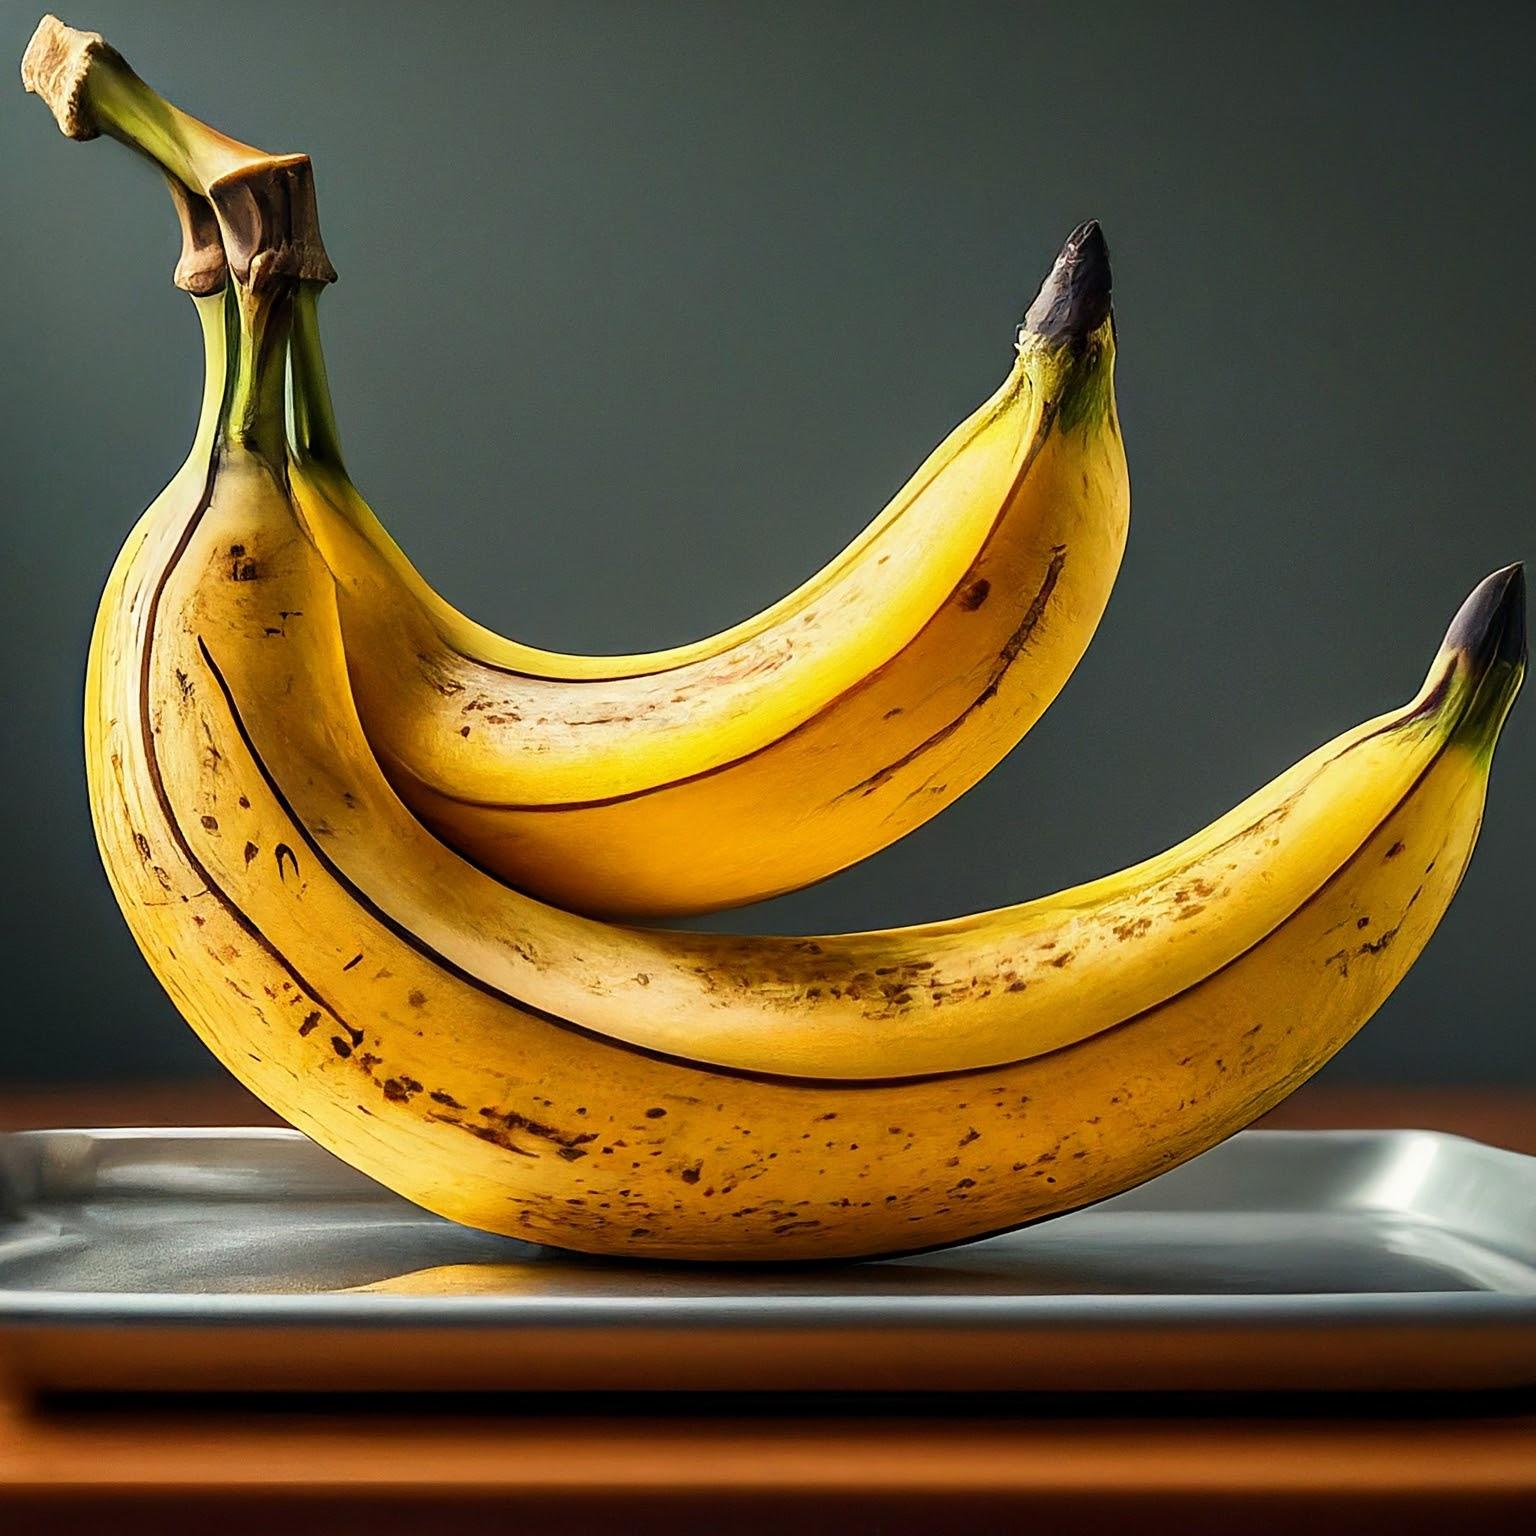

In [74]:
## display image to sanity check
display(Image.open(downloaded_file))

### 5. Make a prediction

In [75]:
# Add batch dimension
preprocessed_image = np.expand_dims(preprocessed_image, axis=0) 

# Get predictions
predictions = model(preprocessed_image)
class_probabilities = tf.nn.softmax(predictions)  # Get probabilities
predicted_class = tf.argmax(class_probabilities).numpy()

print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {class_probabilities}")

Predicted class: [0 0 0 0 0 0]
Class probabilities: [[0.13289773 0.13289921 0.316925   0.1514788  0.13290116 0.13289797]]


get a single predicted class label, using the index of the highest probability. 

In [76]:
# predicted_class_index = tf.argmax(class_probabilities).numpy()
# print(f"Predicted Class Index: {predicted_class_index}")  

#### Get predicted class 

And finally download the `label_map.json` to lookup the predicted class name when making prediction so we have a useful output

In [88]:
bucket = storage_client.bucket(BUCKET_NAME)
blob = bucket.blob("label_map.json")
label_map_json_string = blob.download_as_string()
label_map = json.loads(label_map_json_string)

predicted_class_index = tf.argmax(class_probabilities, axis=-1).numpy()[0]  # Extract scalar value
# Get the predicted class name (assuming you have predicted_class_index)
predicted_class_name = [label for label, index in label_map.items() if index == predicted_class_index][0]

print("Input File:       ", downloaded_file, "\n")
print("=" * 30, " Prediction Response", "=" * 30) 
print("\n", f"Predicted Class Name: {predicted_class_name}", "\n")
print("=" * 80)



Input File:        banana_ripe_cookie_sheet_99437_20240910153933.jpg 

==============================  Prediction Response ==============================

 Predicted Class Name: banana_ripe 



### Cleanup downloaded image

Delete the downloaded image file to keep local directory clean

In [ ]:
if os.path.exists(downloaded_file):  # Check if the file exists
    os.remove(downloaded_file)
    print(f"Deleted downloaded image file: {downloaded_file}")
else:
    print(f"Downloaded image file not found: {downloaded_file}")